In [1]:
import os
import pickle
import numpy as np
from scipy.special import kl_div
from scipy.stats import pearsonr
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
#import config InlineBackend.figure_format = 'svg'
# import tensorflow as tf
# # silencing tensorflow warnings
# import logging
# logging.getLogger('tensorflow').setLevel(logging.FATAL)
from datetime import datetime
# tf.__version__ # printint out tensorflow version used
import stable_baselines3
import sb3_contrib
from stable_baselines3.common.callbacks import BaseCallback
# from stable_baselines3.results_plotter import load_results, ts2xy
from stable_baselines3.common.results_plotter import load_results, ts2xy
import optuna
# from stable_baselines3.bench import Monitor
from stable_baselines3.common.monitor import Monitor
#from stable_baselines3.common.policies import MlpPolicy
from stable_baselines3.common import results_plotter
from sb3_contrib.common.maskable.evaluation import evaluate_policy
from sb3_contrib import MaskablePPO
from stable_baselines3.common.vec_env import DummyVecEnv
#stable_baselines.__version__ # printing out stable_baselines version used
import gym
import pickle
import cProfile 
import pandas as pd
import ast
import seaborn as sns
font = { 'family' : 'sans-serif',
                'weight' : 'normal',
                'size'   : 11}
matplotlib.rc('font', **font)

In [2]:
current_directory = os.getcwd()

exp_id = "2022-03-10v45nsfU100GR2" # best uniform 10K
# exp_id = "2022-03-15v45nsfUp5100GR3" # best non-uniform 10K
# exp_id = "2022-02-23v45nsfnotfbR3" # best for Chen traffic matrix 
# exp_id = "2022-03-25v45nsfP100GR4" # best for population-based traffic matrix 

# exp_id = "2022-03-07v7nsfU100GnomaskR5"
# eval_name = "_no_tfb"
# eval_name = "_no_tfb_population"
# eval_name = "_no_tfb_population_s1"
# eval_name = "_no_tfb_30_60"
eval_name = "_no_tfb_30_60_acc"

# eval_name = "_no_tfb_service_lengths"
# eval_name = "_no_tfb_more_snaps"

# eval_name = "_no_tfb"
route_dir = "/Users/joshnevin/RL_FOCSLab/tmp/RWAFOCS-ppo/"
eval_dir = route_dir+exp_id+"/_core_0/eval_results"+eval_name

# JOCN results 
# uniform no tfb
# eval_dir_h = route_dir+"2022-02-24nsfnotfbuniheuristics_eval/eval_results_no_tfb"  # 100G, k=5, 10k requests
# eval_dir_h = route_dir+"2022-03-11nsfU100Gheuristics_eval/eval_results_no_tfb" # with service distribution
# eval_dir_h = route_dir+"2022-03-11nsfU100Gheuristics_eval/eval_results_no_tfb_more_snaps" # with service distribution
# eval_dir_r = route_dir+"2022-03-11nsf100Gheuristics_eval" # random results (made a slight error with file naming)
# eval_dir_h = route_dir+"2022-03-11nsfU100Gheuristics_eval/eval_results_no_tfb_service_lengths" # with service distribution
# eval_dir_h = route_dir+"2022-03-11nsfU100Gheuristics_evalheuristics_eval/eval_results_no_tfb_30_60"
eval_dir_h = route_dir+"2022-03-11nsfU100Gheuristics_evalheuristics_eval/eval_results_no_tfb_30_60_acc"


# population-based no tfb
# eval_dir_h = route_dir+"2022-03-25nsfP100Gheuristics_eval/eval_results_no_tfb"
# eval_dir_h = route_dir+"2022-03-28nsfP100Gs1heuristics_eval/eval_results_no_tfb"

# non-uniform no tfb
# eval_dir_h = route_dir+"2022-03-04nsfUp50100G10kRheuristics_eval/eval_results_no_tfb" # 100G, k=5, 10k requests
# eval_dir_h = route_dir+"2022-03-11nsfU50100Gheuristics_eval/eval_results_no_tfb_more_snaps" # with service distribution
# eval_dir_h = route_dir+"2022-03-11nsfU50100Gheuristics_eval/eval_results_no_tfb_rand" # with service distribution


# binary occupancy results, uniform no tfb
# eval_dir_h = route_dir+"2022-03-18nsfU100Gbofxdheuristics_eval/eval_results_no_tfb"  # binary occupancy
# eval_dir_h = route_dir+"2022-03-18nsfU100Gbofxdheuristics_eval/eval_results_no_tfb"  # binary occupancy
# eval_dir_h = route_dir+"2022-03-23nsfU100Gbo10chheuristics_eval/eval_results_no_tfb" # with 12.5%, 25%, 37.5%, 50%, 62.5%, 75%, 87.5%, 100% service distribution

# non-uniform tfb
# eval_dir_h = route_dir+"2022-03-11nsfU50100Gheuristics_eval/eval_results_tfb" # with service distribution

# uniform tfb
# eval_dir_h = route_dir+"2022-03-11nsfU100Gheuristics_eval/eval_results_tfb" # with service distribution


# eval_dir_h = route_dir+"2022-02-24nsfunik3heuristics_eval/eval_results_no_tfb"
# eval_dir_h = route_dir+"2022-03-01nsfuni200Gk3heuristics_eval/eval_results_no_tfb"
# eval_dir_h = route_dir+"2022-03-03nsfuni500G2kRk5heuristics_eval/eval_results_no_tfb" # 500G, k=5, 2k requests 

# UNIFORM 50% perturbation NSFNET
# eval_dir_h = route_dir+"2022-03-04nsfUp50500G2kRheuristics_eval/eval_results_no_tfb" 

# "GRAVITY" NSFNET 
# eval_dir_h = route_dir+"2022-02-23v42nsftfb"+"/_core_0/eval_results"+"_tfb"
# eval_dir_h = route_dir+"2022-02-23v42nsftfbR3"+"/_core_0/eval_results"+"_no_tfb"
# eval_dir_h = route_dir+"2022-02-24nsfgravityk3heuristics_eval/eval_results_no_tfb"

# UNIFORM DTAG
# eval_dir_h = route_dir+"2022-02-24dtagnotfbuniheuristics_eval/eval_results_no_tfb" # 100G, k=5, 10k requests
# eval_dir_h = route_dir+"2022-02-24dtagunik3heuristics_eval/eval_results_no_tfb"  # 100G, k=3, 10k requests
# eval_dir_h = route_dir+"2022-03-01dtaguni200Gheuristics_eval/eval_results_no_tfb"  # 200G, k=5, 5k requests
# eval_dir_h = route_dir+"2022-03-01dtaguni200Gk3heuristics_eval/eval_results_no_tfb" # 200G, k=3, 5k requests
# eval_dir_h = route_dir+"2022-03-01dtaguni200G75kRk3heuristics_eval/eval_results_no_tfb" # 200G, k=5, 7.5k requests
# UNIFORM 50% perturbation DTAG
# eval_dir_h = route_dir+"2022-03-04dtagUp50500G2kRheuristics_eval/eval_results_no_tfb" # 500G, k=5, 2k requests 

In [3]:
def get_info(eval_dir, model, get_dist):
    df = pd.read_csv(eval_dir+"/evaluation_"+model+".monitor.csv", skiprows=1)
    eval_eps = df.index.values
    rewards = df['r'].to_numpy()
    sim_time = df['t'].to_numpy()
    services_accepted_ep = df['episode_services_accepted'].to_numpy()
    services_processed_ep = df['episode_services_processed'].to_numpy()
    services_accepted = df['services_accepted'].to_numpy()
    services_processed = df['services_processed'].to_numpy()
    throughput = df['throughput']/1e12
    if get_dist:
#         service_dist_125pc = df['service_distribution_125pc']
#         service_dist_25pc = df['service_distribution_25pc']
#         service_dist_375pc = df['service_distribution_375pc']
#         service_dist_50pc = df['service_distribution_50pc']
#         service_dist_625pc = df['service_distribution_625pc']
#         service_dist_75pc = df['service_distribution_75pc']
#         service_dist_875pc = df['service_distribution_875pc']
        service_dist_30pc = df['service_distribution_30pc']
        service_dist_60pc = df['service_distribution_60pc']
        service_dist = df['service_distribution']
        accepted_service_lengths = df['accepted_service_lengths']
#         return rewards, eval_eps, sim_time, services_accepted_ep, services_processed_ep, services_accepted, services_processed, throughput, service_dist, service_dist_125pc, service_dist_25pc, service_dist_375pc, service_dist_50pc, service_dist_625pc, service_dist_75pc, service_dist_875pc, accepted_service_lengths
        return rewards, eval_eps, sim_time, services_accepted_ep, services_processed_ep, services_accepted, services_processed, throughput, service_dist, service_dist_30pc, service_dist_60pc, accepted_service_lengths    
    else:
        return rewards, eval_eps, sim_time, services_accepted_ep, services_processed_ep, services_accepted, services_processed, throughput
def get_cum_results(eval_dir, model):
    df = pd.read_csv(eval_dir+"/evaluation_"+model+".monitor.csv", skiprows=1)
#     cum_services_accepted = df['episode_cum_services_accepted'].to_numpy()
#     cum_services_processed = df['episode_cum_services_processed'].to_numpy()
    cum_services_accepted = df['episode_cum_services_accepted']
    cum_services_processed = df['episode_cum_services_processed']
    return cum_services_accepted, cum_services_processed
def get_services(service_dist, iter_num):
    service_dist = service_dist[iter_num]
    service_dist = ast.literal_eval(service_dist)
    service_dist = np.array(service_dist).reshape(22,100)  # NOTE! HAVE HARD CODED NUMBER OF EDGES AND CHANNELS!
    return service_dist
def reorder_edges(serdist, edge_inds):
    idx = np.array(edge_inds)
    idx[edge_inds] = np.arange(len(edge_inds))
    return serdist[idx, :]
def get_all_services(service_dist_rl, num_edges, num_channels, num_evals):
    arr = np.zeros([num_edges,num_channels,num_evals])
    for i in range(num_evals):
        arr[:,:,i] = get_services(service_dist_rl, i)
    return arr
def get_services_accepted_snapshots(cum_services_accepted, snap_inds, eval_ind):
    cum_services_accepted = ast.literal_eval(cum_services_accepted[eval_ind])
    services_accepted_snaps = []
    for i in snap_inds:
        services_accepted_snaps.append(cum_services_accepted[i])
    return services_accepted_snaps
def get_all_accepted_snaps(cum_services_accepted, snap_inds, n_evals):
    services_accepted_snaps = np.zeros([n_evals, len(snap_inds)])
    for i in range(n_evals):
        services_accepted_snaps[i,:] = get_services_accepted_snapshots(cum_services_accepted, snap_inds, i)
    return services_accepted_snaps
def get_accepted_service_lengths(accepted_service_lengths, iter_num):
    return ast.literal_eval(accepted_service_lengths[iter_num])
def get_all_accepted_service_lengths(accepted_service_lengths, num_accepted, num_evals):
    arr = []
    for i in range(num_evals):
        arr.append(get_accepted_service_lengths(accepted_service_lengths, i))
    return arr

In [4]:
get_service_dist = True
if not get_service_dist:
    rewards_rl, eval_eps_rl, sim_time_rl, services_accepted_ep_rl, services_processed_ep_rl, services_accepted_rl, services_processed_rl, throughput_rl = get_info(eval_dir, 'rl', False)
    rewards_kspff, eval_eps_kspff, sim_time_kspff, services_accepted_ep_kspff, services_processed_ep_kspff, services_accepted_kspff, services_processed_kspff, throughput_kspff = get_info(eval_dir_h, 'kspff', False)
    rewards_ffksp, eval_eps_ffksp, sim_time_ffksp, services_accepted_ep_ffksp, services_processed_ep_ffksp, services_accepted_ffksp, services_processed_ffksp, throughput_ffksp = get_info(eval_dir_h, 'ffksp', False)
#     rewards_camu, eval_eps_camu, sim_time_camu, services_accepted_ep_camu, services_processed_ep_camu, services_accepted_camu, services_processed_camu, throughput_camu = get_info(eval_dir_h, 'camu', False)
    rewards_kspmu, eval_eps_kspmu, sim_time_kspmu, services_accepted_ep_kspmu, services_processed_ep_kspmu, services_accepted_kspmu, services_processed_kspmu, throughput_kspmu = get_info(eval_dir_h, 'kspmu', False)
else:
    rewards_rl, eval_eps_rl, sim_time_rl, services_accepted_ep_rl, services_processed_ep_rl, services_accepted_rl, services_processed_rl, throughput_rl, service_dist_rl, service_dist_rl_30pc, service_dist_rl_60pc, accepted_service_lengths_rl = get_info(eval_dir, 'rl', True)
    rewards_kspff, eval_eps_kspff, sim_time_kspff, services_accepted_ep_kspff, services_processed_ep_kspff, services_accepted_kspff, services_processed_kspff, throughput_kspff, service_dist_kspff, service_dist_kspff_30pc, service_dist_kspff_60pc, accepted_service_lengths_kspff = get_info(eval_dir_h, 'kspff', True)
    rewards_ffksp, eval_eps_ffksp, sim_time_ffksp, services_accepted_ep_ffksp, services_processed_ep_ffksp, services_accepted_ffksp, services_processed_ffksp, throughput_ffksp, service_dist_ffksp, service_dist_ffksp_30pc, service_dist_ffksp_60pc, accepted_service_lengths_ffksp  = get_info(eval_dir_h, 'ffksp', True)
#     rewards_camu, eval_eps_camu, sim_time_camu, services_accepted_ep_camu, services_processed_ep_camu, services_accepted_camu, services_processed_camu, throughput_camu, service_dist_camu, service_dist_camu_25pc, service_dist_camu_50pc, service_dist_camu_75pc  = get_info(eval_dir_h, 'camu', True)
    rewards_kspmu, eval_eps_kspmu, sim_time_kspmu, services_accepted_ep_kspmu, services_processed_ep_kspmu, services_accepted_kspmu, services_processed_kspmu, throughput_kspmu, service_dist_kspmu, service_dist_kspmu_30pc, service_dist_kspmu_60pc, accepted_service_lengths_kspmu  = get_info(eval_dir_h, 'kspmu', True)

In [5]:
pickle.dump(np.mean(services_accepted_ep_rl), open("results/"+exp_id+"_mean.pkl",'wb'))
pickle.dump(np.median(services_accepted_ep_rl), open("results/"+exp_id+"_median.pkl",'wb'))
pickle.dump(np.std(services_accepted_ep_rl), open("results/"+exp_id+"_std.pkl",'wb'))

In [6]:
print("Mean:",np.mean(services_accepted_ep_rl))
print("Median:",np.median(services_accepted_ep_rl))
print("Std:",np.std(services_accepted_ep_rl))

Mean: 6869.01
Median: 6872.0
Std: 71.17267663928342


In [7]:
print("RL:",np.mean(services_accepted_ep_rl))
print("kSP-FF:",np.mean(services_accepted_ep_kspff))
print("FF-kSP:",np.mean(services_accepted_ep_ffksp))
# print("CA-MU:",np.mean(services_accepted_ep_camu))
print("kSP-MU:",np.mean(services_accepted_ep_kspmu))

RL: 6869.01
kSP-FF: 6701.0
FF-kSP: 6819.64
kSP-MU: 6805.04


In [8]:
print("RL:",np.median(services_accepted_ep_rl))
print("kSP-FF:",np.median(services_accepted_ep_kspff))
print("FF-kSP:",np.median(services_accepted_ep_ffksp))
# print("CA-MU:",np.median(services_accepted_ep_camu))
print("kSP-MU:",np.median(services_accepted_ep_kspmu))

RL: 6872.0
kSP-FF: 6710.0
FF-kSP: 6818.0
kSP-MU: 6801.5


In [9]:
print("RL:",np.std(services_accepted_ep_rl))
print("kSP-FF:",np.std(services_accepted_ep_kspff))
print("FF-kSP:",np.std(services_accepted_ep_ffksp))
# print("CA-MU:",np.std(services_accepted_ep_camu))
print("kSP-MU:",np.std(services_accepted_ep_kspmu))

RL: 71.17267663928342
kSP-FF: 54.843595797504015
FF-kSP: 63.342327080712785
kSP-MU: 80.27638756197243


In [10]:
print("RL:",np.mean(rewards_rl))
print("kSP-FF:",np.mean(rewards_kspff))
print("FF-kSP:",np.mean(rewards_ffksp))
# print("CA-MU:",np.mean(rewards_camu))
print("kSP-MU:",np.mean(rewards_kspmu))

RL: 3738.02
kSP-FF: 3402.0
FF-kSP: 3639.28
kSP-MU: 3610.08


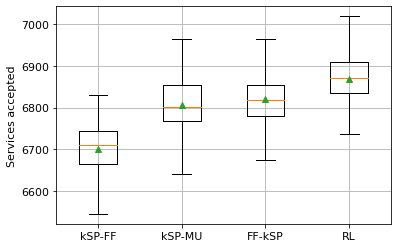

In [11]:
f, ax = plt.subplots()
dict_plt = {'kSP-FF':services_accepted_ep_kspff,'kSP-MU':services_accepted_ep_kspmu,'FF-kSP':services_accepted_ep_ffksp, 'RL':services_accepted_ep_rl}
#dict_plt = {'FF-kSP':services_accepted_ep_ffksp, 'RL':services_accepted_ep_rl}
bp = plt.boxplot(dict_plt.values(),showfliers=False,showmeans=True)
ax.set_xticklabels(dict_plt.keys())
plt.ylabel("Services accepted")
# ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
# plt.ylim([2285, 2305])
plt.grid()
# plt.savefig('figures/'+exp_id+eval_name+'boxplot.jpeg', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
medians = [item.get_ydata()[0] for item in bp['medians']]
means = [item.get_ydata()[0] for item in bp['means']]
print(f'Medians: {medians}\n'
      f'Means:   {means}')

In [ ]:
minimums = [round(item.get_ydata()[0], 1) for item in bp['caps']][::2]
maximums = [round(item.get_ydata()[0], 1) for item in bp['caps']][1::2]
print(f'Minimums: {minimums}\n'
      f'Maximums: {maximums}')

In [ ]:
q1 = [round(min(item.get_ydata()), 1) for item in bp['boxes']]
q3 = [round(max(item.get_ydata()), 1) for item in bp['boxes']]
IQR = [q3[i] - q1[i] for i in range(len(q1))]
print(IQR)

In [ ]:
(6820 + 6793 + 6828 + 6804)/4

In [ ]:
(6855+ 6869 + 6829 + 6778 + 6789)/5

In [ ]:
6100 - (10000 - 6100)

In [ ]:
6373 - 6295

**Accepted service path length distribution**:

In [ ]:
service_lengths_rl = get_all_accepted_service_lengths(accepted_service_lengths_rl, len(accepted_service_lengths_rl), 100)
service_lengths_kspff = get_all_accepted_service_lengths(accepted_service_lengths_kspff, len(accepted_service_lengths_kspff), 100)
service_lengths_ffksp = get_all_accepted_service_lengths(accepted_service_lengths_ffksp, len(accepted_service_lengths_ffksp), 100)
service_lengths_kspmu = get_all_accepted_service_lengths(accepted_service_lengths_kspmu, len(accepted_service_lengths_kspmu), 100)

In [ ]:
plt.hist(service_lengths_rl[0])
plt.show()

In [ ]:
plt.hist(service_lengths_kspff[0])
plt.show()

In [ ]:
plt.hist(service_lengths_kspmu[0])
plt.show()

In [ ]:
plt.hist(service_lengths_ffksp[0])
plt.show()

In [ ]:
def get_mean_lens(num_eval, service_lengths):
    return [np.mean(service_lengths[i]) for i in range(num_eval)]

In [ ]:
mean_lens_rl = get_mean_lens(100, service_lengths_rl)
mean_lens_kspff = get_mean_lens(100, service_lengths_kspff)
mean_lens_kspmu = get_mean_lens(100, service_lengths_kspmu)
mean_lens_ffksp = get_mean_lens(100, service_lengths_ffksp)

In [ ]:
print(np.mean(mean_lens_rl))
print(np.mean(mean_lens_kspff))
print(np.mean(mean_lens_kspmu))
print(np.mean(mean_lens_ffksp))

**Random agent analysis**

In [ ]:
rewards_rand, eval_eps_rand, sim_time_rand, services_accepted_ep_rand, services_processed_ep_rand, services_accepted_rand, services_processed_rand, throughput_rand  = get_info(eval_dir_r, 'rand', False)

In [ ]:
print("Mean:",np.mean(services_accepted_ep_rand))
print("Median:",np.median(services_accepted_ep_rand))
print("Std:",np.std(services_accepted_ep_rand))

In [ ]:
cum_services_accepted_rl, cum_services_processed_rl = get_cum_results(eval_dir, 'rl')
cum_services_accepted_kspff, cum_services_processed_kspff = get_cum_results(eval_dir_h, 'kspff')
cum_services_accepted_ffksp, cum_services_processed_ffksp = get_cum_results(eval_dir_h, 'ffksp')
cum_services_accepted_kspmu, cum_services_processed_kspmu = get_cum_results(eval_dir_h, 'kspmu')

In [ ]:
# snap_inds = [1249, 2499, 3749, 4999, 6249, 7499, 8749]
snap_inds = [1249, 2499, 3749, 4999, 6249, 7499]

n_evals = 100
services_accepted_snaps_mean_rl = np.mean(get_all_accepted_snaps(cum_services_accepted_rl, snap_inds, n_evals), axis=0)
services_accepted_snaps_mean_kspff = np.mean(get_all_accepted_snaps(cum_services_accepted_kspff, snap_inds, n_evals),axis=0)
services_accepted_snaps_mean_ffksp = np.mean(get_all_accepted_snaps(cum_services_accepted_ffksp, snap_inds, n_evals), axis=0)
services_accepted_snaps_mean_kspmu = np.mean(get_all_accepted_snaps(cum_services_accepted_kspmu, snap_inds, n_evals), axis=0)

In [ ]:
print(services_accepted_snaps_mean_rl)
print(services_accepted_snaps_mean_kspff)
print(services_accepted_snaps_mean_ffksp)
print(services_accepted_snaps_mean_kspmu)

**Service distribution stuff!**  
Questions to answer:  
* how consistent is the placement of services across evaluation runs? Do any patterns emerge?
* How similar is the RL agent allocation of services to the heuristics?
* What is the trend with respect to edge length? 

In [12]:
serdist_rl = get_all_services(service_dist_rl, 22, 100, 100)
serdist_kspff = get_all_services(service_dist_kspff, 22, 100, 100)
serdist_ffksp = get_all_services(service_dist_ffksp, 22, 100, 100)
serdist_kspmu = get_all_services(service_dist_kspmu, 22, 100, 100)

serdist_rl_30pc = get_all_services(service_dist_rl_30pc, 22, 100, 100)
serdist_kspff_30pc = get_all_services(service_dist_kspff_30pc, 22, 100, 100)
serdist_ffksp_30pc = get_all_services(service_dist_ffksp_30pc, 22, 100, 100)
serdist_kspmu_30pc = get_all_services(service_dist_kspmu_30pc, 22, 100, 100)

serdist_rl_60pc = get_all_services(service_dist_rl_60pc, 22, 100, 100)
serdist_kspff_60pc = get_all_services(service_dist_kspff_60pc, 22, 100, 100)
serdist_ffksp_60pc = get_all_services(service_dist_ffksp_60pc, 22, 100, 100)
serdist_kspmu_60pc = get_all_services(service_dist_kspmu_60pc, 22, 100, 100)

In [13]:
len_ordered_edge_inds = [21,20,17,16,18,9,6,3,19,15,14,12,4,10,0,8,13,1,11,5,7,2]
serdist_rl_mean = reorder_edges(np.mean(serdist_rl, axis=2), len_ordered_edge_inds)
serdist_kspff_mean = reorder_edges(np.mean(serdist_kspff, axis=2), len_ordered_edge_inds)
serdist_ffksp_mean = reorder_edges(np.mean(serdist_ffksp, axis=2), len_ordered_edge_inds)
serdist_kspmu_mean = reorder_edges(np.mean(serdist_kspmu, axis=2), len_ordered_edge_inds)

serdist_rl_mean_30pc = reorder_edges(np.mean(serdist_rl_30pc, axis=2), len_ordered_edge_inds)
serdist_kspff_mean_30pc = reorder_edges(np.mean(serdist_kspff_30pc, axis=2), len_ordered_edge_inds)
serdist_ffksp_mean_30pc = reorder_edges(np.mean(serdist_ffksp_30pc, axis=2), len_ordered_edge_inds)
serdist_kspmu_mean_30pc = reorder_edges(np.mean(serdist_kspmu_30pc, axis=2), len_ordered_edge_inds)

serdist_rl_mean_60pc = reorder_edges(np.mean(serdist_rl_60pc, axis=2), len_ordered_edge_inds)
serdist_kspff_mean_60pc = reorder_edges(np.mean(serdist_kspff_60pc, axis=2), len_ordered_edge_inds)
serdist_ffksp_mean_60pc = reorder_edges(np.mean(serdist_ffksp_60pc, axis=2), len_ordered_edge_inds)
serdist_kspmu_mean_60pc = reorder_edges(np.mean(serdist_kspmu_60pc, axis=2), len_ordered_edge_inds)

**Look at service distribution after 30% of the episode:**

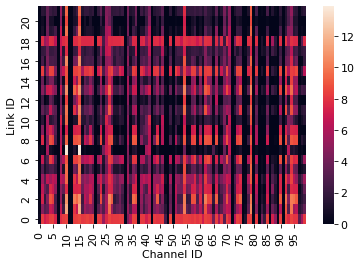

In [31]:
ax = sns.heatmap(serdist_rl_mean_30pc, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_30pc_'+exp_id+'_ac.jpeg', dpi=300,bbox_inches='tight')
plt.show()

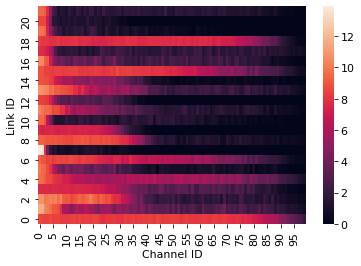

In [15]:
ax = sns.heatmap(serdist_kspff_mean_30pc, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_30pc_uniform_kspff_ac.jpeg', dpi=300,bbox_inches='tight')
plt.show()

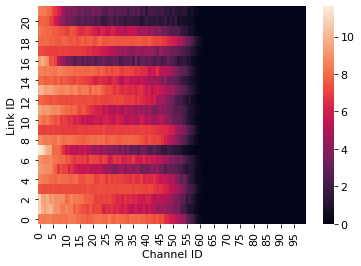

In [16]:
ax = sns.heatmap(serdist_ffksp_mean_30pc, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_30pc_uniform_ffksp_ac.jpeg', dpi=300,bbox_inches='tight')
plt.show()

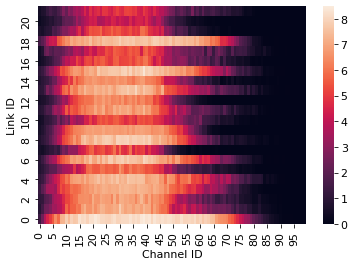

In [17]:
ax = sns.heatmap(serdist_kspmu_mean_30pc, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_30pc_uniform_kspmu_ac.jpeg', dpi=300,bbox_inches='tight')
plt.show()

**Look at service distribution after 60% of the episode:**

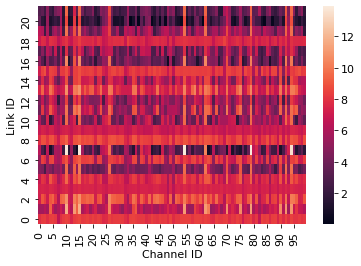

In [18]:
ax = sns.heatmap(serdist_rl_mean_60pc, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_60pc_'+exp_id+'_ac.jpeg', dpi=300,bbox_inches='tight')
plt.show()

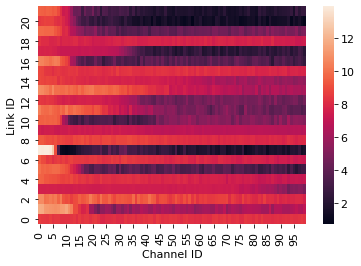

In [19]:
ax = sns.heatmap(serdist_kspff_mean_60pc, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_60pc_uniform_kspff_ac.jpeg', dpi=300,bbox_inches='tight')
plt.show()

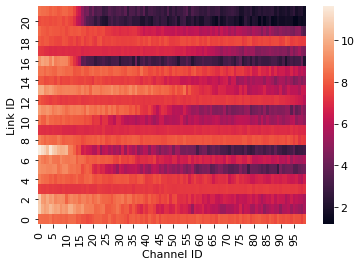

In [20]:
ax = sns.heatmap(serdist_ffksp_mean_60pc, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_60pc_uniform_ffksp_ac.jpeg', dpi=300,bbox_inches='tight')
plt.show()

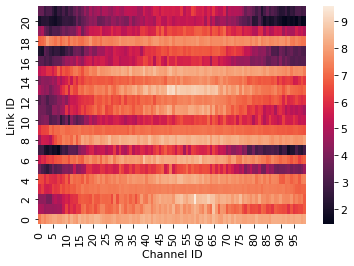

In [21]:
ax = sns.heatmap(serdist_kspmu_mean_60pc, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_60pc_uniform_kspmu_ac.jpeg', dpi=300,bbox_inches='tight')
plt.show()

**Look at distribution across the channels - is it uniform?**

In [ ]:
mean_channel_dist_30pc = np.mean(serdist_rl_mean_30pc, axis=0) / np.max(np.mean(serdist_rl_mean_30pc, axis=0))
mean_channel_dist_60pc = np.mean(serdist_rl_mean_60pc, axis=0) / np.max(np.mean(serdist_rl_mean_60pc, axis=0))

In [ ]:
mean_channel_dist_ffksp_30pc = np.mean(serdist_ffksp_mean_30pc, axis=0) / np.max(np.mean(serdist_ffksp_mean_30pc, axis=0))
mean_channel_dist_kspff_30pc = np.mean(serdist_kspff_mean_30pc, axis=0) / np.max(np.mean(serdist_kspff_mean_30pc, axis=0))
mean_channel_dist_kspmu_30pc = np.mean(serdist_kspmu_mean_30pc, axis=0) / np.max(np.mean(serdist_kspmu_mean_30pc, axis=0))

mean_channel_dist_ffksp_60pc = np.mean(serdist_ffksp_mean_60pc, axis=0) / np.max(np.mean(serdist_ffksp_mean_60pc, axis=0))
mean_channel_dist_kspff_60pc = np.mean(serdist_kspff_mean_60pc, axis=0) / np.max(np.mean(serdist_kspff_mean_60pc, axis=0))
mean_channel_dist_kspmu_60pc = np.mean(serdist_kspmu_mean_60pc, axis=0) / np.max(np.mean(serdist_kspmu_mean_60pc, axis=0))

In [22]:
mean_channel_dist_30pc = np.mean(serdist_rl_mean_30pc, axis=0)
mean_channel_dist_60pc = np.mean(serdist_rl_mean_60pc, axis=0) 

In [23]:
mean_channel_dist_ffksp_30pc = np.mean(serdist_ffksp_mean_30pc, axis=0) 
mean_channel_dist_kspff_30pc = np.mean(serdist_kspff_mean_30pc, axis=0) 
mean_channel_dist_kspmu_30pc = np.mean(serdist_kspmu_mean_30pc, axis=0) 

mean_channel_dist_ffksp_60pc = np.mean(serdist_ffksp_mean_60pc, axis=0) 
mean_channel_dist_kspff_60pc = np.mean(serdist_kspff_mean_60pc, axis=0) 
mean_channel_dist_kspmu_60pc = np.mean(serdist_kspmu_mean_60pc, axis=0) 

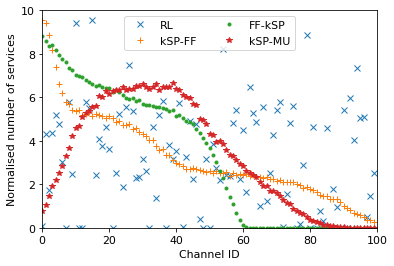

In [37]:
plt.plot(mean_channel_dist_30pc, 'x', label='RL')
plt.plot(mean_channel_dist_kspff_30pc, '+', label='kSP-FF')
plt.plot(mean_channel_dist_ffksp_30pc, '.', label='FF-kSP')
plt.plot(mean_channel_dist_kspmu_30pc, '*', label='kSP-MU')
plt.legend(ncol=2)
plt.xlabel("Channel ID")
plt.ylabel("Normalised number of services")
plt.ylim([0,10])
plt.xlim([0,100])
plt.savefig('figures/channel_distribution_comp_30pc_nonnormalised_ac', dpi=500,bbox_inches='tight')
plt.show() 

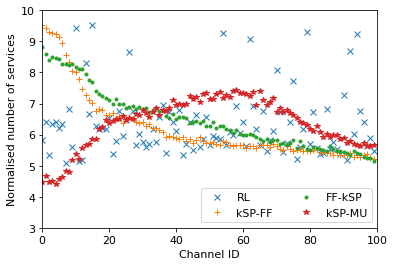

In [36]:
# f, ax = plt.subplots()
plt.plot(mean_channel_dist_60pc, 'x', label='RL')
plt.plot(mean_channel_dist_kspff_60pc, '+', label='kSP-FF')
plt.plot(mean_channel_dist_ffksp_60pc, '.', label='FF-kSP')
plt.plot(mean_channel_dist_kspmu_60pc, '*', label='kSP-MU')
plt.legend(ncol=2, loc=4)
plt.xlabel("Channel ID")
plt.ylabel("Normalised number of services")
plt.ylim([3,10])
plt.xlim([0,100])
# ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
# f.patch.set_facecolor('w')
plt.savefig('figures/channel_distribution_comp_60pc_nonnormalised_ac', dpi=500,bbox_inches='tight')
plt.show() 

**Look at distribution across links**

In [ ]:
mean_link_dist_30pc = np.mean(serdist_rl_mean_30pc, axis=1) / np.max(np.mean(serdist_rl_mean_30pc, axis=1))
mean_link_dist_60pc = np.mean(serdist_rl_mean_60pc, axis=1) / np.max(np.mean(serdist_rl_mean_60pc, axis=1))

In [ ]:
mean_link_dist_ffksp_30pc = np.mean(serdist_ffksp_mean_30pc, axis=1) / np.max(np.mean(serdist_ffksp_mean_30pc, axis=1))
mean_link_dist_kspff_30pc = np.mean(serdist_kspff_mean_30pc, axis=1) / np.max(np.mean(serdist_kspff_mean_30pc, axis=1))
mean_link_dist_kspmu_30pc = np.mean(serdist_kspmu_mean_30pc, axis=1) / np.max(np.mean(serdist_kspmu_mean_30pc, axis=1))
mean_link_dist_ffksp_60pc = np.mean(serdist_ffksp_mean_60pc, axis=1) / np.max(np.mean(serdist_ffksp_mean_60pc, axis=1))
mean_link_dist_kspff_60pc = np.mean(serdist_kspff_mean_60pc, axis=1) / np.max(np.mean(serdist_kspff_mean_60pc, axis=1))
mean_link_dist_kspmu_60pc = np.mean(serdist_kspmu_mean_60pc, axis=1) / np.max(np.mean(serdist_kspmu_mean_60pc, axis=1))

In [26]:
mean_link_dist_30pc = np.mean(serdist_rl_mean_30pc, axis=1)
mean_link_dist_60pc = np.mean(serdist_rl_mean_60pc, axis=1) 

In [27]:
mean_link_dist_ffksp_30pc = np.mean(serdist_ffksp_mean_30pc, axis=1) 
mean_link_dist_kspff_30pc = np.mean(serdist_kspff_mean_30pc, axis=1)
mean_link_dist_kspmu_30pc = np.mean(serdist_kspmu_mean_30pc, axis=1) 
mean_link_dist_ffksp_60pc = np.mean(serdist_ffksp_mean_60pc, axis=1) 
mean_link_dist_kspff_60pc = np.mean(serdist_kspff_mean_60pc, axis=1) 
mean_link_dist_kspmu_60pc = np.mean(serdist_kspmu_mean_60pc, axis=1) 

MAE of link distribution for RL vs heuristics - very different to FF-kSP at the start, similar at the end...

In [41]:
# print(np.mean(abs(mean_link_dist_30pc - mean_link_dist_ffksp_30pc)))
print(np.mean(abs(mean_link_dist_60pc - mean_link_dist_ffksp_60pc)))
# print(np.mean(abs(mean_link_dist_30pc - mean_link_dist_kspff_30pc)))
print(np.mean(abs(mean_link_dist_60pc - mean_link_dist_kspff_60pc)))
# print(np.mean(abs(mean_link_dist_30pc - mean_link_dist_kspmu_30pc)))
print(np.mean(abs(mean_link_dist_60pc - mean_link_dist_kspmu_60pc)))

0.5046363636363635
0.36262272727272743
0.3148954545454543


In [ ]:
0.24/0.08

In [ ]:
0.10/0.06

In [ ]:
0.06/0.04

In [ ]:
mean_link_dist_30pc

In [ ]:
link_ids.astype('str')

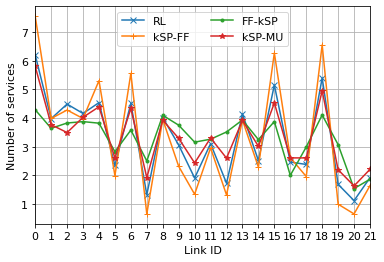

In [38]:
link_ids = np.arange(0,22,1)
f, ax = plt.subplots()
plt.plot(link_ids, mean_link_dist_30pc, marker='x', label='RL')
plt.plot(link_ids, mean_link_dist_kspff_30pc, marker='+', label='kSP-FF')
plt.plot(link_ids, mean_link_dist_ffksp_30pc, marker='.', label='FF-kSP')
plt.plot(link_ids, mean_link_dist_kspmu_30pc, marker='*', label='kSP-MU')
plt.xlabel("Link ID")
plt.ylabel("Number of services")
plt.xlim([0,21])
ax.set_xticks(link_ids)
ax.set_xticklabels(link_ids.astype('str'))
plt.legend(ncol=2, loc='upper center')
plt.grid()
plt.savefig('figures/link_distribution_comp_30pc_marker_nonnormalised_ac', dpi=500,bbox_inches='tight')
plt.show() 

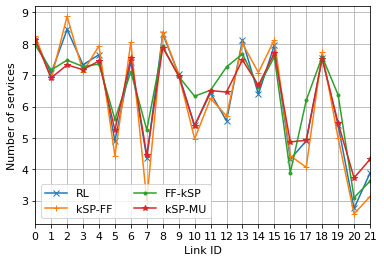

In [39]:
link_ids = np.arange(0,22,1)
f, ax = plt.subplots()
plt.plot(link_ids, mean_link_dist_60pc, marker='x', label='RL')
plt.plot(link_ids, mean_link_dist_kspff_60pc, marker='+', label='kSP-FF')
plt.plot(link_ids, mean_link_dist_ffksp_60pc, marker='.', label='FF-kSP')
plt.plot(link_ids, mean_link_dist_kspmu_60pc, marker='*', label='kSP-MU')
plt.xlabel("Link ID")
plt.ylabel("Number of services")
plt.xlim([0,21])
ax.set_xticks(link_ids)
ax.set_xticklabels(link_ids.astype('str'))
plt.grid()
plt.legend(ncol=2)
# ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
# f.patch.set_facecolor('w')
plt.savefig('figures/link_distribution_comp_60pc_marker_nonnormalised_ac', dpi=500,bbox_inches='tight')
plt.show() 

Mapping of topology to edge indices and then to length ordered edge indices:  
S D Length Original length-ordered  
1 2 1000 -->   0  --> 14  
1 3 1500 -->   1  --> 17  
1 8 2400 -->   2  --> 21  
2 3 600  -->   3   --> 7  
2 4 700  -->   4   --> 12  
3 6 1800 -->   5   --> 19  
4 5 600  -->   6   --> 6  
4 11 1900-->   7   --> 20  
5 6 1200 -->   8   --> 15  
5 7 600  -->   9   --> 5  
6 10 1000-->   10  --> 13  
6 14 1800-->   11  --> 18  
7 8 700  -->   12  --> 11  
7 10 1300-->   13  --> 16  
8 9 700  -->   14  --> 10  
9 10 700 -->   15  --> 9  
9 12 300 -->   16  --> 3  
9 13 300 -->   17  --> 2  
11 12 600-->   18  --> 4  
11 13 700-->   19  --> 8  
12 14 300-->   20  --> 1  
13 14 100-->   21  --> 0  

In [ ]:
len_ordered_edge_inds = [21,20,17,16,18,9,6,3,19,15,14,12,4,10,0,8,13,1,11,5,7,2]
len(len_ordered_edge_inds)

**Topology link utilisation plot**

In [ ]:
class MplColorHelper:

  def __init__(self, cmap_name, start_val, stop_val):
    self.cmap_name = cmap_name
    self.cmap = plt.get_cmap(cmap_name)
    self.norm = matplotlib.colors.Normalize(vmin=start_val, vmax=stop_val)
    self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

  def get_rgb(self, val):
    return self.scalarMap.to_rgba(val)
import matplotlib.cm as cm
import matplotlib.colors as colors
from scipy.io import savemat, loadmat

In [ ]:
COL_30pc = MplColorHelper('hot', np.min(mean_link_dist_30pc), np.max(mean_link_dist_30pc))
COL_60pc = MplColorHelper('hot', np.min(mean_link_dist_60pc), np.max(mean_link_dist_60pc))

In [ ]:
fig, ax = plt.subplots()
df = pd.DataFrame({"x": link_ids, "y": mean_link_dist_30pc})
ax.scatter(df.x, df.y, color=COL_30pc.get_rgb(mean_link_dist_30pc))
ax.set_xticks(df.x)
plt.show()

In [ ]:
fig, ax = plt.subplots()
df = pd.DataFrame({"x": link_ids, "y": mean_link_dist_60pc})
ax.scatter(df.x, df.y, color=COL_60pc.get_rgb(mean_link_dist_60pc))
ax.set_xticks(df.x)
plt.show()

In [ ]:
COL_60pc.get_rgb(mean_link_dist_60pc)

In [ ]:
colours_dict_30pc = {"rgb_utils_30pc": COL.get_rgb(mean_link_dist_30pc)}
colours_dict_60pc = {"rgb_utils_60pc": COL.get_rgb(mean_link_dist_60pc)}

savemat("results/rgb_link_utils_30pc.mat", colours_dict_30pc)
savemat("results/rgb_link_utils_60pc.mat", colours_dict_60pc)

In [ ]:
mean_link_dist_30pc_dict = {"link_utils_30pc": mean_link_dist_30pc}
mean_link_dist_60pc_dict = {"link_utils_60pc": mean_link_dist_60pc}

savemat("results/link_utils_30pc.mat", mean_link_dist_30pc_dict)
savemat("results/link_utils_60pc.mat", mean_link_dist_60pc_dict)

**Eval timing**

In [ ]:
rl_timing = pickle.load(open("/Users/joshnevin/RL_FOCSLab/eval_timing/2022-03-10v45nsfU100GR2_rl.pkl",'rb'))
kspff_timing = pickle.load(open("/Users/joshnevin/RL_FOCSLab/eval_timing/2022-03-30nsfU100Gtiming_kspff.pkl",'rb'))
kspmu_timing = pickle.load(open("/Users/joshnevin/RL_FOCSLab/eval_timing/2022-03-30nsfU100Gtiming_kspmu.pkl",'rb'))
ffksp_timing = pickle.load(open("/Users/joshnevin/RL_FOCSLab/eval_timing/2022-03-30nsfU100Gtiming_ffksp.pkl",'rb'))

In [ ]:
print(rl_timing/60)
print(kspff_timing/60)
print(kspmu_timing/60)
print(ffksp_timing/60)

Calculate average over multiple runs

In [ ]:
exp_id_r1 = "2022-03-07v7nsfU100G"
exp_id_r2 = "2022-03-07v7nsfU100GR2"
exp_id_r3 = "2022-03-07v7nsfU100GR3"
exp_id_r4 = "2022-03-07v7nsfU100GR4"
exp_id_r5 = "2022-03-07v7nsfU100GR5"

R1_mean = pickle.load(open("results/"+exp_id_r1+"_mean.pkl",'rb'))
R2_mean = pickle.load(open("results/"+exp_id_r2+"_mean.pkl",'rb'))
R3_mean = pickle.load(open("results/"+exp_id_r3+"_mean.pkl",'rb'))
R4_mean = pickle.load(open("results/"+exp_id_r4+"_mean.pkl",'rb'))
# R5_mean = pickle.load(open("results/"+exp_id_r5+"_mean.pkl",'rb'))
ave_mean = np.mean([R1_mean,R2_mean,R3_mean,R4_mean])
R1_median = pickle.load(open("results/"+exp_id_r1+"_median.pkl",'rb'))
R2_median = pickle.load(open("results/"+exp_id_r2+"_median.pkl",'rb'))
R3_median = pickle.load(open("results/"+exp_id_r3+"_median.pkl",'rb'))
R4_median = pickle.load(open("results/"+exp_id_r4+"_median.pkl",'rb'))
# R5_median = pickle.load(open("results/"+exp_id_r5+"_median.pkl",'rb'))
ave_median = np.mean([R1_median,R2_median,R3_median,R4_median])
R1_std = pickle.load(open("results/"+exp_id_r1+"_std.pkl",'rb'))
R2_std = pickle.load(open("results/"+exp_id_r2+"_std.pkl",'rb'))
R3_std = pickle.load(open("results/"+exp_id_r3+"_std.pkl",'rb'))
R4_std = pickle.load(open("results/"+exp_id_r4+"_std.pkl",'rb'))
# R5_std = pickle.load(open("results/"+exp_id_r5+"_std.pkl",'rb'))
ave_std = np.mean([R1_std,R2_std,R3_std,R4_std])

In [ ]:
print("Mean:",ave_mean)
print("Median:",ave_median)
print("Std:",ave_std)

Plotting for multiple RL agents:

In [ ]:
current_directory = os.getcwd()

exp_id_m_u = "2022-03-10v45nsfU100GR2"  
exp_id_nm_u = "2022-03-15v45nsfU100GnomaskR3"

exp_id_m_nu = "2022-03-15v45nsfUp5100GR3"
exp_id_nm_nu = "2022-03-16v45nsfUp50100GnomaskR5"  

eval_name = "_no_tfb"
route_dir = "/Users/joshnevin/RL_FOCSLab/tmp/RWAFOCS-ppo/"
eval_dir_m_u = route_dir+exp_id_m_u+"/_core_0/eval_results"+eval_name
eval_dir_nm_u = route_dir+exp_id_nm_u+"/_core_0/eval_results"+eval_name
eval_dir_m_nu = route_dir+exp_id_m_nu+"/_core_0/eval_results"+eval_name
eval_dir_nm_nu = route_dir+exp_id_nm_nu+"/_core_0/eval_results"+eval_name

In [ ]:
rewards_rl_m_u, eval_eps_rl_m_u, sim_time_rl_m_u, services_accepted_ep_rl_m_u, services_processed_ep_rl_m_u, services_accepted_rl_m_u, services_processed_rl_m_u, throughput_rl_m_u = get_info(eval_dir_m_u, 'rl', False)
rewards_rl_nm_u, eval_eps_rl_nm_u, sim_time_rl_nm_u, services_accepted_ep_rl_nm_u, services_processed_ep_rl_nm_u, services_accepted_rl_nm_u, services_processed_rl_nm_u, throughput_rl_nm_u = get_info(eval_dir_nm_u, 'rl', False)
rewards_rl_m_nu, eval_eps_rl_m_nu, sim_time_rl_m_nu, services_accepted_ep_rl_m_nu, services_processed_ep_rl_m_nu, services_accepted_rl_m_nu, services_processed_rl_m_nu, throughput_rl_m_nu = get_info(eval_dir_m_nu, 'rl', False)
rewards_rl_nm_nu, eval_eps_rl_nm_nu, sim_time_rl_nm_nu, services_accepted_ep_rl_nm_nu, services_processed_ep_rl_nm_nu, services_accepted_rl_nm_nu, services_processed_rl_nm_nu, throughput_rl_nm_nu = get_info(eval_dir_nm_nu, 'rl', False)

In [ ]:
f, ax = plt.subplots()
# dict_plt = {'IAM RL U':services_accepted_ep_rl_m_u,'Stan. RL U':services_accepted_ep_rl_nm_u,
#                 'IAM RL non-U':services_accepted_ep_rl_m_nu,'Stan. RL non-U':services_accepted_ep_rl_nm_nu}
dict_plt = {'Random':services_accepted_ep_rand,'St. RL':services_accepted_ep_rl_nm_u,'Masked RL':services_accepted_ep_rl_m_u,'kSP-FF':services_accepted_ep_kspff,'kSP-MU':services_accepted_ep_kspmu,'FF-kSP':services_accepted_ep_ffksp,}
# dict_plt = {'kSP-FF':services_accepted_ep_kspff,'kSP-MU':services_accepted_ep_kspmu,'FF-kSP':services_accepted_ep_ffksp, 'RL':services_accepted_ep_rl}
bp = plt.boxplot(dict_plt.values(),showfliers=False,showmeans=True)
ax.set_xticklabels(dict_plt.keys())
plt.ylabel("Services accepted")
# ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
plt.grid()
# plt.savefig('figures/masked_vs_unmasked_nonuniform_boxplot.png', dpi=500,bbox_inches='tight')
# plt.savefig('figures/masked_vs_unmasked_uniform_boxplot.png', dpi=500,bbox_inches='tight')
# plt.savefig('figures/masked_vs_unmasked_with_random_uniform_boxplot.png', dpi=500,bbox_inches='tight')
plt.savefig('figures/masked_vs_unmasked_with_random_and_heuristics_uniform_boxplot.png', dpi=500,bbox_inches='tight')
plt.show()

In [ ]:
topology = 'nsfnet'
f, ax = plt.subplots()
bp = dict_plt = {'kSP-FF':services_accepted_ep_kspff,'kSP-MU':services_accepted_ep_kspmu,'FF-kSP':services_accepted_ep_ffksp,
            'RL':services_accepted_ep_rl_1}
bp = plt.boxplot(dict_plt.values(),showfliers=False,showmeans=True)
ax.set_xticklabels(dict_plt.keys())
plt.ylabel("Services accepted")
# ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
# plt.legend([bp["boxes"][0]], ['A'], loc='upper right')
plt.grid()
#plt.savefig('figures/servicesaccepted_bestresults'+topology+eval_name_plot+'modelA.png', dpi=500,bbox_inches='tight')
plt.show()

In [ ]:
medians = [item.get_ydata()[0] for item in bp['medians']]
means = [item.get_ydata()[0] for item in bp['means']]
print(f'Medians: {medians}\n'
      f'Means:   {means}')

In [ ]:
minimums = [round(item.get_ydata()[0], 1) for item in bp['caps']][::2]
maximums = [round(item.get_ydata()[0], 1) for item in bp['caps']][1::2]
print(f'Minimums: {minimums}\n'
      f'Maximums: {maximums}')
q1 = [round(min(item.get_ydata()), 1) for item in bp['boxes']]
q3 = [round(max(item.get_ydata()), 1) for item in bp['boxes']]
# print(f'Q1: {q1}\n'
#       f'Q3: {q3}')
IQR = [q3[i] - q1[i] for i in range(len(q1))]
print(IQR)

Timing results

In [ ]:
rl_time = pickle.load(open("/Users/joshnevin/RL_FOCSLab/eval_timing/"+exp_id+"_RL.pkl", 'rb'))
kspff_time = pickle.load(open("/Users/joshnevin/RL_FOCSLab/eval_timing/"+exp_id+"_kspff.pkl", 'rb'))
ffksp_time = pickle.load(open("/Users/joshnevin/RL_FOCSLab/eval_timing/"+exp_id+"_ffksp.pkl", 'rb'))
camu_time = pickle.load(open("/Users/joshnevin/RL_FOCSLab/eval_timing/"+exp_id+"_camu.pkl", 'rb'))
kspmu_time = pickle.load(open("/Users/joshnevin/RL_FOCSLab/eval_timing/"+exp_id+"_kspmu.pkl", 'rb'))

In [ ]:
print(rl_time)
print(kspff_time)
print(ffksp_time)
print(camu_time)
print(kspmu_time)